In [34]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler


#Custome graph format style sheet
plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = True
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.eps'
if not 'location' in locals():
    #save location.  First one is for running on home PC, second for running on the work laptop.  May need to make a global change
    location = 'E:\\Documents\\Dan\\Code\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'
    #location = 'C:\\Users\\dhendrickson\\Documents\\github\\FigsAndPlots\\FigsAndPlotsDocument\\Figures\\'



In [35]:
# Task Specific includes:

#import scipy.special as sp
import math
import matplotlib.animation as animation
import time
from numpy import inf
# Choose which EFIT_Class to use:
# import EFIT_Class as EFIT
# import EFIT_Class_StressLargerVelocity as EFIT
import EFIT_Class_OrignalEqualGrid as EFIT
# import EFIT_Class_Parallel_EqualGrid as EFIT
# import EFIT_Class_VelocityLargerStress as EFIT

In [36]:
# set Constants:
PoissonRatio = 0.3
YoungModulus = 20 * (10**9)
mu = 80 * (10**9)         #First Lame Parameter
lmbda = 2 * mu * PoissonRatio / (1 - 2 * PoissonRatio)     #second Lame Parameter
rho = 7800       #density

#Calculate speed of longitudinal and transverse waves
cl = np.sqrt((lmbda + 2* mu)/rho)
ct = np.sqrt(mu/rho)

print(cl,ct)

#Choose ferquency to be used for excitment
frequency = 40000

#calculate wave length
omegal = cl / frequency
omegat = ct / frequency

# about 1foot (0.3m) of just the web of 175lbs rail 
# BeamLength = 0.3
# BeamHeight = 0.0762
# BeamWidth = 0.0381
BeamLength = 0.02
BeamHeight = 0.02
BeamWidth = 0.02

5991.446895152781 3202.563076101743


In [37]:
#Run for 6 Cycles:
runtime = 5.0 / frequency 

#Set time step and grid step to be 10 steps per frequency and ten steps per wavelength respectively
ts = 1 / frequency / 25    #time step
gs = min(omegal, omegat) / 25    #grid step

Tsteps = int(math.ceil(runtime / ts)) + 1       #total Time STeps

gl = int(math.ceil(BeamLength / gs)) *2        #number of grid points
gh = int(math.ceil(BeamHeight / gs)) *2
gw = int(math.ceil(BeamWidth / gs)) *2


In [38]:
#Initialize EFIT Model
Rail = EFIT.EFIT(gl, gw, gh, ts, gs)

#Set Material Properties consitant througout
Rail.Gp[0,:,:,:] = rho  #constant Density
Rail.Gp[1,:,:,:] = lmbda #Constant first Lamee parameter 
Rail.Gp[2,:,:,:] = mu  #constant second Lamee parameter


In [39]:
#Run main function for time:
CenterXResults = []
CenterYResults = []
CenterZResults = []

t=0
TempZ=Rail.VelocityCut(2)
CenterZResults.append((TempZ,t))
np.savetxt(str(t)+'.csv', TempZ, delimiter=",")

for i in range(Tsteps - 1):
    t = (i+1) * ts
   
    #update Velocity:
    for x in range(gl):
        for y in range(gh):
            for z in range(gw):
                Rail.UpdateVelocity(x,y,z)

    if i >= 2 and i <= 4: Rail.ForcingFunctionImpulse(10, 0.1,2,1)
    #if i>=2 and i<=20:
    #    Rail.ForcingFunctionWave(t, frequency/2, 1,0.01,2,1)
    #else:
    #    Rail.ForcingFunctionWave(t, frequency, 0)
    
    #Update Stresses at next half step:
    for x in range(gl):
        for y in range(gh):
            for z in range(gw):
                Rail.UpdateStresses(x,y,z)

    print(str(i+1) + ' of ' + str(Tsteps-1) +' time steps. time is: '+ "{:.3e}".format(t)) #str(t))
    TempZ=Rail.VelocityCut(0)
    CenterZResults.append((TempZ,t))

    # Store results mid process for latter animating
    if i < 10 or i % 10 == 1:
    

        #np.savetxt(str(i)+'V0.csv', Rail.VelocityCut(0), delimiter=",")
        #np.savetxt(str(i)+'V1.csv', Rail.VelocityCut(1), delimiter=",")
        np.savetxt(str(i)+'V2.csv', Rail.VelocityCut(2), delimiter=",")
        #np.savetxt(str(i)+'S0.csv', Rail.StressCut(0,1,1), delimiter=",")
        np.savetxt(str(i)+'S1.csv', Rail.StressCut(1,1,1), delimiter=",")
        #np.savetxt(str(i)+'S2.csv', Rail.StressCut(2,1,1), delimiter=",")

    #TempZ=Rail.StressCut(2,1,1)
    #np.savetxt(str(i)+'S11.csv', TempZ, delimiter=",")
    #TempZ=Rail.StressCut(2,1,0)
        #np.savetxt(str(i)+'S10.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,1,2)
        #np.savetxt(str(i)+'S12.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,0,0)
        #np.savetxt(str(i)+'S00.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,0,2)
        #np.savetxt(str(i)+'S02.csv', TempZ, delimiter=",")
        #TempZ=Rail.StressCut(2,2,2)
        #np.savetxt(str(i)+'S22.csv', TempZ, delimiter=",")


1 of 126 time steps. time is: 1.000e-06
2 of 126 time steps. time is: 2.000e-06
3 of 126 time steps. time is: 3.000e-06
4 of 126 time steps. time is: 4.000e-06
5 of 126 time steps. time is: 5.000e-06
6 of 126 time steps. time is: 6.000e-06
7 of 126 time steps. time is: 7.000e-06
8 of 126 time steps. time is: 8.000e-06
9 of 126 time steps. time is: 9.000e-06
10 of 126 time steps. time is: 1.000e-05
11 of 126 time steps. time is: 1.100e-05
12 of 126 time steps. time is: 1.200e-05
13 of 126 time steps. time is: 1.300e-05
14 of 126 time steps. time is: 1.400e-05
15 of 126 time steps. time is: 1.500e-05
16 of 126 time steps. time is: 1.600e-05
17 of 126 time steps. time is: 1.700e-05
18 of 126 time steps. time is: 1.800e-05
19 of 126 time steps. time is: 1.900e-05
20 of 126 time steps. time is: 2.000e-05
21 of 126 time steps. time is: 2.100e-05
22 of 126 time steps. time is: 2.200e-05
23 of 126 time steps. time is: 2.300e-05
24 of 126 time steps. time is: 2.400e-05
25 of 126 time steps. tim

c:\Users\dhendrickson\Documents\Code\3D_EFIT\EFIT_Class_OrignalEqualGrid.py:372: RuntimeWarning: overflow encountered in square
  Results = np.sqrt(Component0**2+Component1**2+Component2**2)
c:\Users\dhendrickson\Documents\Code\3D_EFIT\EFIT_Class_OrignalEqualGrid.py:372: RuntimeWarning: overflow encountered in add
  Results = np.sqrt(Component0**2+Component1**2+Component2**2)
c:\Users\dhendrickson\Documents\Code\3D_EFIT\EFIT_Class_OrignalEqualGrid.py:402: RuntimeWarning: overflow encountered in square
  Results = np.sqrt(Component0**2+Component1**2+Component2**2)
c:\Users\dhendrickson\Documents\Code\3D_EFIT\EFIT_Class_OrignalEqualGrid.py:402: RuntimeWarning: overflow encountered in add
  Results = np.sqrt(Component0**2+Component1**2+Component2**2)


105 of 126 time steps. time is: 1.050e-04
106 of 126 time steps. time is: 1.060e-04
107 of 126 time steps. time is: 1.070e-04
108 of 126 time steps. time is: 1.080e-04
109 of 126 time steps. time is: 1.090e-04
110 of 126 time steps. time is: 1.100e-04
111 of 126 time steps. time is: 1.110e-04
112 of 126 time steps. time is: 1.120e-04
113 of 126 time steps. time is: 1.130e-04
114 of 126 time steps. time is: 1.140e-04
115 of 126 time steps. time is: 1.150e-04
116 of 126 time steps. time is: 1.160e-04
117 of 126 time steps. time is: 1.170e-04
118 of 126 time steps. time is: 1.180e-04
119 of 126 time steps. time is: 1.190e-04
120 of 126 time steps. time is: 1.200e-04
121 of 126 time steps. time is: 1.210e-04
122 of 126 time steps. time is: 1.220e-04
123 of 126 time steps. time is: 1.230e-04
124 of 126 time steps. time is: 1.240e-04
125 of 126 time steps. time is: 1.250e-04
126 of 126 time steps. time is: 1.260e-04


C:\Users\dhendrickson\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
MovieWriter ffmpeg unavailable; using Pillow instead.


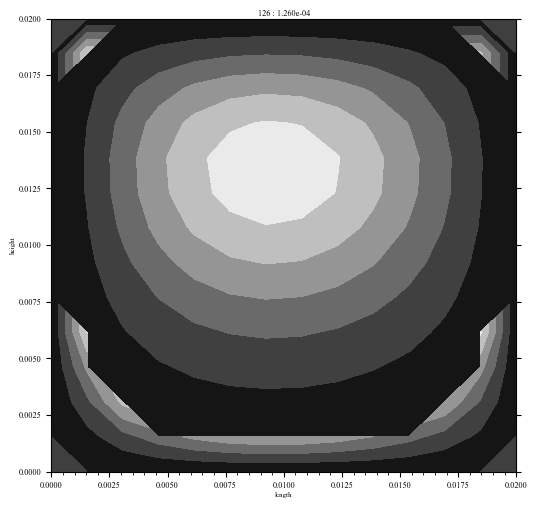

In [40]:
y = np.linspace(0, BeamHeight, np.shape(CenterZResults[0][0])[1])
x = np.linspace(0, BeamLength, np.shape(CenterZResults[0][0])[0])
x,y = np.meshgrid(x,y)

fig = plt.figure(figsize=(6.0,BeamHeight/BeamLength*6.0), dpi=100)
ax = plt.axes(xlim=(0, BeamLength), ylim=(0, BeamHeight))  
plt.ylabel(r'height')
plt.xlabel(r'length')

# animation function
def animate(i): 
    z = np.matrix(CenterZResults[i][0][:,:]).T
    plt.title(str(i) + ' : ' + "{:.3e}".format(t))
    cont = plt.contourf(x, y, z, levels=5, cmap='gray') #,vmin=-100, vmax=100)
    #time.sleep(1)
    return cont  

anim = animation.FuncAnimation(fig, animate, frames=np.shape(CenterZResults)[0])

anim.save('animationZ.gif')

In [41]:
#x,y,z, Rail.MaxX, Rail.MaxY, Rail.MaxZ
#np.sqrt(Rail.Gv[2,1,:,:]**2+Rail.Gv[0,1,:,:]**2+Rail.Gv[1,1,:,:]**2)